<a href="https://colab.research.google.com/github/nassimhafici/Complete-Python-3-Bootcamp/blob/master/projet_immobilier_web_scrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recherche de Condos sur Centris - web scraping
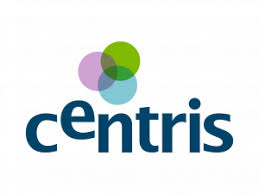
---

> Dernier Update : 2021-03-03

> Auteur: Nassim Hafici, nassim.hafici@gmail.com

### Imports librairies

In [ ]:
# BeautifulSoup et autres librairies
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
from datetime import datetime
import time
import csv
import pytz
from tqdm import tqdm


# Installer Selenium et les préalables, aucun exécutable à installer préalablement si IDE = Colab
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 911kB 5.2MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [49.8 kB]
Hit:12 http://ppa.launch

### Variables Globales


In [ ]:
## GLOBAL
HEADERS = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2228.0 Safari/537.36'})
CENTRIS_URL = "https://www.centris.ca/fr/condo~a-vendre~montreal-ile"
REALTOR_URL = "https://www.realtor.ca/map#ZoomLevel=14&Center=45.527634%2C-73.562406&LatitudeMax=45.55063&LongitudeMax=-73.49443&LatitudeMin=45.50463&LongitudeMin=-73.63038&Sort=6-D&PGeoIds=g30_f25dfkk6&GeoName=Montreal%2C%20QC&PropertyTypeGroupID=1&PropertySearchTypeId=3&TransactionTypeId=2&PriceMin=300000&PriceMax=500000&BedRange=2-2&BathRange=1-1&OwnershipTypeGroupId=2&Currency=CAD"
DUPROPRIO_URL = "https://duproprio.com/"

ATTRIBUTES = ('price','is_new','full_address', 'quartier', 'salle_de_bains', 'chambres', 'hyperlink','mls_number')
BIG_LINE = '='*80+'\n'
    

###Fonctions: response et parse html

In [ ]:
# FUNCTIONS

def get_response_container(url):
    return requests.get(url, headers = HEADERS)
    
def parse_html(response
               ,keydiv = 'div'
               ,classhtml = 'shell' 
               ,method = 'beautifulsoup'):
  
  if method == 'beautifulsoup':
    response = response.text
  elif method == 'selenium':
    response = response.page_source

  html_soup = BeautifulSoup(response, 'html.parser')

  return html_soup.find_all(keydiv, class_ = classhtml)


### Fonctions: retrouver les attributs des condos

In [ ]:

def get_current_page(container):
    current_page =  (container.find_all('div', class_="pager-current")[0]
                  .text
                  .replace(' ','')
                  .split("/")[0])
    return current_page

def get_price(container):
  
  price = (container.find_all('div', class_="price")[0]
                  .text
                  .replace('$','')
                  .replace('\n','')
                  .replace(u'\xa0', '')
                  )
  if '+TPS/TVQ' in price:
    price = price.replace('  +TPS/TVQ','')
    price = round(int(price)*1.15,0)
    is_new = 1
  else:
    price = int(price)
    is_new = 0
  return price, is_new

def get_full_address(container):
    full_address = (container
                    .find_all('span', class_="address")[0]
                    .text)
    return full_address

def get_quartier(container, full_address):
  if 'Quartier' in full_address:
    quartier = (full_address[full_address
                            .find('Quartier')+9:])
  elif '(' in full_address:
    quartier = full_address[full_address.find("(")+1:full_address.find(")")]
  else:
    quartier = full_adress.split(' ')[-1]
  quartier = quartier.replace('\n','')
  return quartier

def get_sdb(container):
  try:
    salle_de_bains = int(container
                        .find_all('div', class_="sdb")[0]
                        .text)
  except:
    salle_de_bains = 0
  return salle_de_bains

def get_chambres(container):
  try:
    chambres = int(container
                .find_all('div', class_="cac")[0]
                .text)
  except:
    chambres = 0
  return chambres

def get_mls_number(container):
  mls_number =   (container
                    .find_all('a', class_="a-more-detail")[1]
                    .text
                    .split('\n'))
  # enlever les cochonneries et empty string pour avoir le 0idx élément
  mls_number = list(filter(None, mls_number))[0] 
  return mls_number

def get_hyperlink(container):
  hyperlink = 'https://www.centris.ca'+container.find_all('a')[0].get('href')
  return hyperlink

### Fonctions: scraper l'information sur chaque page

In [ ]:
#-- ATTRIBUTES FROM CONDO --#
def condo_attributes_to_dict(container):
  price, is_new = get_price(container)
  full_address = get_full_address(container)
  quartier = get_quartier(container, full_address)
  salle_de_bains = get_sdb(container)
  chambres = get_chambres(container)
  mls_number = get_mls_number(container)
  hyperlink = get_hyperlink(container)
  #current_page = get_current_page(container)

  attributes_dict = {}
  for i in ATTRIBUTES:
      attributes_dict[i] = locals()[i]

  return attributes_dict

#-- ALL PROPRETIES --#
def scrap_all_propreties(house_containers
                       ,site = 'CENTRIS'
                       ,method = 'beautifulsoup'
                       ,attributes = ATTRIBUTES
                       ,is_info_print = False):

  df_output = pd.DataFrame()
  if house_containers != []: 
    for container in house_containers:
      try:
        dict_out = condo_attributes_to_dict(container)
        df_output = df_output.append(dict_out, ignore_index=True)
      except:
        pass
                        
      #if not int(output_infos['price'].replace(' ','')) > 500000:
      if is_info_print:
        for item in ATTRIBUTES: 
          print(f"{item}: {dict_out[item]}\n")
          print(BIG_LINE)
  return df_output

 
def scrap_real_eastate_propreties(driver):
  """
  Return all informations available for the propreties on the current web page
  and click on the next one.
  """
  WebDriverWait(driver, timeout=5).until(lambda x: x.find_element_by_class_name('address'))
  print('Zizou (ZZzz)\n')
  time.sleep(3)

  house_containers = parse_html(driver, method='selenium')
  df_output = scrap_all_propreties(house_containers)

  driver.find_element_by_class_name('next').click()
  print('\nClick on next page...\n')
  return df_output

def get_current_time(version, geo_zone = 'America/Montreal'):
  timezone = pytz.timezone(geo_zone)
  now = datetime.now(tz=timezone)
  if version == 'FULL':
    return now.strftime("-%Y-%m-%d-%H:%M")
  elif version == 'PARTIAL':
    return now.strftime("%Y-%m-%d")

### Main script -> Exécuter

In [ ]:
## ------------------------ MAIN -------------------------------------##
PAGES = 320 # Pour l'instant manuel, on peut aller chercher le nombre de page max, mais la flemme
driver = webdriver.Chrome('chromedriver',options=chrome_options)
driver.get(CENTRIS_URL)

current_time = get_current_time('FULL')
print(f"{2*BIG_LINE}LISTE DES CONDOS AU {current_time} \n{2*BIG_LINE}")

output_lst = []
for page in tqdm(range(PAGES)):
    print(f"Page: {page+1}/{PAGES}")
    output_df = scrap_real_eastate_propreties(driver)
    output_lst.append(output_df)
print('----------------Scraping Done-----------------------\n')


df_final = pd.concat(output_lst)
df_final["date"] = get_current_time('PARTIAL')
df_final.to_csv(f"all_condos{current_time}.csv", index=False ,encoding='utf-8-sig')
print('Fichier .csv enregistré sur le répertoire local courant')

  0%|          | 0/320 [00:00<?, ?it/s]

LISTE DES CONDOS AU -2021-03-29-13:53 

Page: 1/320
Zizou (ZZzz)



  0%|          | 1/320 [00:03<18:58,  3.57s/it]


Click on next page...

Page: 2/320
Zizou (ZZzz)



  1%|          | 2/320 [00:06<18:34,  3.51s/it]


Click on next page...

Page: 3/320
Zizou (ZZzz)



  1%|          | 3/320 [00:10<18:16,  3.46s/it]


Click on next page...

Page: 4/320
Zizou (ZZzz)



  1%|▏         | 4/320 [00:13<18:02,  3.43s/it]


Click on next page...

Page: 5/320
Zizou (ZZzz)



  2%|▏         | 5/320 [00:16<17:53,  3.41s/it]


Click on next page...

Page: 6/320
Zizou (ZZzz)



  2%|▏         | 6/320 [00:20<17:45,  3.39s/it]


Click on next page...

Page: 7/320
Zizou (ZZzz)



  2%|▏         | 7/320 [00:23<17:47,  3.41s/it]


Click on next page...

Page: 8/320
Zizou (ZZzz)



  2%|▎         | 8/320 [00:27<17:38,  3.39s/it]


Click on next page...

Page: 9/320
Zizou (ZZzz)



  3%|▎         | 9/320 [00:30<17:31,  3.38s/it]


Click on next page...

Page: 10/320
Zizou (ZZzz)



  3%|▎         | 10/320 [00:33<17:28,  3.38s/it]


Click on next page...

Page: 11/320
Zizou (ZZzz)



  3%|▎         | 11/320 [00:37<17:22,  3.37s/it]


Click on next page...

Page: 12/320
Zizou (ZZzz)



  4%|▍         | 12/320 [00:40<17:28,  3.40s/it]


Click on next page...

Page: 13/320
Zizou (ZZzz)



  4%|▍         | 13/320 [00:44<17:21,  3.39s/it]


Click on next page...

Page: 14/320
Zizou (ZZzz)



  4%|▍         | 14/320 [00:47<17:16,  3.39s/it]


Click on next page...

Page: 15/320
Zizou (ZZzz)



  5%|▍         | 15/320 [00:50<17:09,  3.37s/it]


Click on next page...

Page: 16/320
Zizou (ZZzz)



  5%|▌         | 16/320 [00:54<17:03,  3.37s/it]


Click on next page...

Page: 17/320
Zizou (ZZzz)



  5%|▌         | 17/320 [00:57<17:10,  3.40s/it]


Click on next page...

Page: 18/320
Zizou (ZZzz)



  6%|▌         | 18/320 [01:00<17:03,  3.39s/it]


Click on next page...

Page: 19/320
Zizou (ZZzz)



  6%|▌         | 19/320 [01:04<16:57,  3.38s/it]


Click on next page...

Page: 20/320
Zizou (ZZzz)



  6%|▋         | 20/320 [01:07<16:51,  3.37s/it]


Click on next page...

Page: 21/320
Zizou (ZZzz)



  7%|▋         | 21/320 [01:11<16:51,  3.38s/it]


Click on next page...

Page: 22/320
Zizou (ZZzz)



  7%|▋         | 22/320 [01:14<16:56,  3.41s/it]


Click on next page...

Page: 23/320
Zizou (ZZzz)



  7%|▋         | 23/320 [01:17<16:50,  3.40s/it]


Click on next page...

Page: 24/320
Zizou (ZZzz)



  8%|▊         | 24/320 [01:21<16:42,  3.39s/it]


Click on next page...

Page: 25/320
Zizou (ZZzz)



  8%|▊         | 25/320 [01:24<16:37,  3.38s/it]


Click on next page...

Page: 26/320
Zizou (ZZzz)



  8%|▊         | 26/320 [01:28<16:36,  3.39s/it]


Click on next page...

Page: 27/320
Zizou (ZZzz)



  8%|▊         | 27/320 [01:31<16:41,  3.42s/it]


Click on next page...

Page: 28/320
Zizou (ZZzz)



  9%|▉         | 28/320 [01:34<16:35,  3.41s/it]


Click on next page...

Page: 29/320
Zizou (ZZzz)



  9%|▉         | 29/320 [01:38<16:31,  3.41s/it]


Click on next page...

Page: 30/320
Zizou (ZZzz)



  9%|▉         | 30/320 [01:41<16:22,  3.39s/it]


Click on next page...

Page: 31/320
Zizou (ZZzz)



 10%|▉         | 31/320 [01:45<16:17,  3.38s/it]


Click on next page...

Page: 32/320
Zizou (ZZzz)



 10%|█         | 32/320 [01:48<16:12,  3.38s/it]


Click on next page...

Page: 33/320
Zizou (ZZzz)



 10%|█         | 33/320 [01:51<16:17,  3.41s/it]


Click on next page...

Page: 34/320
Zizou (ZZzz)



 11%|█         | 34/320 [01:55<16:10,  3.39s/it]


Click on next page...

Page: 35/320
Zizou (ZZzz)



 11%|█         | 35/320 [01:58<16:04,  3.38s/it]


Click on next page...

Page: 36/320
Zizou (ZZzz)



 11%|█▏        | 36/320 [02:01<15:58,  3.37s/it]


Click on next page...

Page: 37/320
Zizou (ZZzz)



 12%|█▏        | 37/320 [02:05<15:52,  3.37s/it]


Click on next page...

Page: 38/320
Zizou (ZZzz)



 12%|█▏        | 38/320 [02:08<15:58,  3.40s/it]


Click on next page...

Page: 39/320
Zizou (ZZzz)



 12%|█▏        | 39/320 [02:12<15:51,  3.39s/it]


Click on next page...

Page: 40/320
Zizou (ZZzz)



 12%|█▎        | 40/320 [02:15<15:45,  3.38s/it]


Click on next page...

Page: 41/320
Zizou (ZZzz)



 13%|█▎        | 41/320 [02:18<15:39,  3.37s/it]


Click on next page...

Page: 42/320
Zizou (ZZzz)



 13%|█▎        | 42/320 [02:22<15:35,  3.36s/it]


Click on next page...

Page: 43/320
Zizou (ZZzz)



 13%|█▎        | 43/320 [02:25<15:42,  3.40s/it]


Click on next page...

Page: 44/320
Zizou (ZZzz)



 14%|█▍        | 44/320 [02:29<15:35,  3.39s/it]


Click on next page...

Page: 45/320
Zizou (ZZzz)



 14%|█▍        | 45/320 [02:32<15:30,  3.38s/it]


Click on next page...

Page: 46/320
Zizou (ZZzz)



 14%|█▍        | 46/320 [02:35<15:23,  3.37s/it]


Click on next page...

Page: 47/320
Zizou (ZZzz)



 15%|█▍        | 47/320 [02:39<15:17,  3.36s/it]


Click on next page...

Page: 48/320
Zizou (ZZzz)



 15%|█▌        | 48/320 [02:42<15:23,  3.40s/it]


Click on next page...

Page: 49/320
Zizou (ZZzz)



 15%|█▌        | 49/320 [02:45<15:15,  3.38s/it]


Click on next page...

Page: 50/320
Zizou (ZZzz)



 16%|█▌        | 50/320 [02:49<15:10,  3.37s/it]


Click on next page...

Page: 51/320
Zizou (ZZzz)



 16%|█▌        | 51/320 [02:52<15:05,  3.37s/it]


Click on next page...

Page: 52/320
Zizou (ZZzz)



 16%|█▋        | 52/320 [02:56<15:00,  3.36s/it]


Click on next page...

Page: 53/320
Zizou (ZZzz)



 17%|█▋        | 53/320 [02:59<14:57,  3.36s/it]


Click on next page...

Page: 54/320
Zizou (ZZzz)



 17%|█▋        | 54/320 [03:02<15:01,  3.39s/it]


Click on next page...

Page: 55/320
Zizou (ZZzz)



 17%|█▋        | 55/320 [03:06<14:56,  3.38s/it]


Click on next page...

Page: 56/320
Zizou (ZZzz)



 18%|█▊        | 56/320 [03:09<14:54,  3.39s/it]


Click on next page...

Page: 57/320
Zizou (ZZzz)



 18%|█▊        | 57/320 [03:12<14:49,  3.38s/it]


Click on next page...

Page: 58/320
Zizou (ZZzz)



 18%|█▊        | 58/320 [03:16<14:49,  3.39s/it]


Click on next page...

Page: 59/320
Zizou (ZZzz)



 18%|█▊        | 59/320 [03:19<14:50,  3.41s/it]


Click on next page...

Page: 60/320
Zizou (ZZzz)



 19%|█▉        | 60/320 [03:23<14:43,  3.40s/it]


Click on next page...

Page: 61/320
Zizou (ZZzz)



 19%|█▉        | 61/320 [03:26<14:36,  3.38s/it]


Click on next page...

Page: 62/320
Zizou (ZZzz)



 19%|█▉        | 62/320 [03:29<14:31,  3.38s/it]


Click on next page...

Page: 63/320
Zizou (ZZzz)



 20%|█▉        | 63/320 [03:33<14:27,  3.37s/it]


Click on next page...

Page: 64/320
Zizou (ZZzz)



 20%|██        | 64/320 [03:36<14:30,  3.40s/it]


Click on next page...

Page: 65/320
Zizou (ZZzz)



 20%|██        | 65/320 [03:40<14:26,  3.40s/it]


Click on next page...

Page: 66/320
Zizou (ZZzz)



 21%|██        | 66/320 [03:43<14:21,  3.39s/it]


Click on next page...

Page: 67/320
Zizou (ZZzz)



 21%|██        | 67/320 [03:46<14:14,  3.38s/it]


Click on next page...

Page: 68/320
Zizou (ZZzz)



 21%|██▏       | 68/320 [03:50<14:08,  3.37s/it]


Click on next page...

Page: 69/320
Zizou (ZZzz)



 22%|██▏       | 69/320 [03:53<14:12,  3.40s/it]


Click on next page...

Page: 70/320
Zizou (ZZzz)



 22%|██▏       | 70/320 [03:57<14:06,  3.38s/it]


Click on next page...

Page: 71/320
Zizou (ZZzz)



 22%|██▏       | 71/320 [04:00<14:00,  3.38s/it]


Click on next page...

Page: 72/320
Zizou (ZZzz)



 22%|██▎       | 72/320 [04:03<13:56,  3.37s/it]


Click on next page...

Page: 73/320
Zizou (ZZzz)



 23%|██▎       | 73/320 [04:07<13:53,  3.37s/it]


Click on next page...

Page: 74/320
Zizou (ZZzz)



 23%|██▎       | 74/320 [04:10<13:57,  3.40s/it]


Click on next page...

Page: 75/320
Zizou (ZZzz)



 23%|██▎       | 75/320 [04:13<13:49,  3.38s/it]


Click on next page...

Page: 76/320
Zizou (ZZzz)



 24%|██▍       | 76/320 [04:17<13:42,  3.37s/it]


Click on next page...

Page: 77/320
Zizou (ZZzz)



 24%|██▍       | 77/320 [04:20<13:37,  3.36s/it]


Click on next page...

Page: 78/320
Zizou (ZZzz)



 24%|██▍       | 78/320 [04:23<13:32,  3.36s/it]


Click on next page...

Page: 79/320
Zizou (ZZzz)



 25%|██▍       | 79/320 [04:27<13:30,  3.36s/it]


Click on next page...

Page: 80/320
Zizou (ZZzz)



 25%|██▌       | 80/320 [04:30<13:44,  3.44s/it]


Click on next page...

Page: 81/320
Zizou (ZZzz)



 25%|██▌       | 81/320 [04:34<13:34,  3.41s/it]


Click on next page...

Page: 82/320
Zizou (ZZzz)



 26%|██▌       | 82/320 [04:37<13:26,  3.39s/it]


Click on next page...

Page: 83/320
Zizou (ZZzz)



 26%|██▌       | 83/320 [04:40<13:20,  3.38s/it]


Click on next page...

Page: 84/320
Zizou (ZZzz)



 26%|██▋       | 84/320 [04:44<13:16,  3.37s/it]


Click on next page...

Page: 85/320
Zizou (ZZzz)



 27%|██▋       | 85/320 [04:47<13:18,  3.40s/it]


Click on next page...

Page: 86/320
Zizou (ZZzz)



 27%|██▋       | 86/320 [04:51<13:11,  3.38s/it]


Click on next page...

Page: 87/320
Zizou (ZZzz)



 27%|██▋       | 87/320 [04:54<13:09,  3.39s/it]


Click on next page...

Page: 88/320
Zizou (ZZzz)



 28%|██▊       | 88/320 [04:57<13:05,  3.38s/it]


Click on next page...

Page: 89/320
Zizou (ZZzz)



 28%|██▊       | 89/320 [05:01<12:59,  3.37s/it]


Click on next page...

Page: 90/320
Zizou (ZZzz)



 28%|██▊       | 90/320 [05:04<13:01,  3.40s/it]


Click on next page...

Page: 91/320
Zizou (ZZzz)



 28%|██▊       | 91/320 [05:08<12:54,  3.38s/it]


Click on next page...

Page: 92/320
Zizou (ZZzz)



 29%|██▉       | 92/320 [05:11<12:48,  3.37s/it]


Click on next page...

Page: 93/320
Zizou (ZZzz)



 29%|██▉       | 93/320 [05:14<12:42,  3.36s/it]


Click on next page...

Page: 94/320
Zizou (ZZzz)



 29%|██▉       | 94/320 [05:18<12:41,  3.37s/it]


Click on next page...

Page: 95/320
Zizou (ZZzz)



 30%|██▉       | 95/320 [05:21<12:44,  3.40s/it]


Click on next page...

Page: 96/320
Zizou (ZZzz)



 30%|███       | 96/320 [05:24<12:37,  3.38s/it]


Click on next page...

Page: 97/320
Zizou (ZZzz)



 30%|███       | 97/320 [05:28<12:31,  3.37s/it]


Click on next page...

Page: 98/320
Zizou (ZZzz)



 31%|███       | 98/320 [05:31<12:27,  3.37s/it]


Click on next page...

Page: 99/320
Zizou (ZZzz)



 31%|███       | 99/320 [05:35<12:23,  3.36s/it]


Click on next page...

Page: 100/320
Zizou (ZZzz)



 31%|███▏      | 100/320 [05:38<12:19,  3.36s/it]


Click on next page...

Page: 101/320
Zizou (ZZzz)



 32%|███▏      | 101/320 [05:41<12:25,  3.40s/it]


Click on next page...

Page: 102/320
Zizou (ZZzz)



 32%|███▏      | 102/320 [05:45<12:18,  3.39s/it]


Click on next page...

Page: 103/320
Zizou (ZZzz)



 32%|███▏      | 103/320 [05:48<12:12,  3.37s/it]


Click on next page...

Page: 104/320
Zizou (ZZzz)



 32%|███▎      | 104/320 [05:51<12:07,  3.37s/it]


Click on next page...

Page: 105/320
Zizou (ZZzz)



 33%|███▎      | 105/320 [05:55<12:03,  3.36s/it]


Click on next page...

Page: 106/320
Zizou (ZZzz)



 33%|███▎      | 106/320 [05:58<12:08,  3.40s/it]


Click on next page...

Page: 107/320
Zizou (ZZzz)



 33%|███▎      | 107/320 [06:02<12:01,  3.39s/it]


Click on next page...

Page: 108/320
Zizou (ZZzz)



 34%|███▍      | 108/320 [06:05<11:58,  3.39s/it]


Click on next page...

Page: 109/320
Zizou (ZZzz)



 34%|███▍      | 109/320 [06:08<11:56,  3.39s/it]


Click on next page...

Page: 110/320
Zizou (ZZzz)



 34%|███▍      | 110/320 [06:12<11:49,  3.38s/it]


Click on next page...

Page: 111/320
Zizou (ZZzz)



 35%|███▍      | 111/320 [06:15<11:51,  3.41s/it]


Click on next page...

Page: 112/320
Zizou (ZZzz)



 35%|███▌      | 112/320 [06:19<11:45,  3.39s/it]


Click on next page...

Page: 113/320
Zizou (ZZzz)



 35%|███▌      | 113/320 [06:22<11:40,  3.38s/it]


Click on next page...

Page: 114/320
Zizou (ZZzz)



 36%|███▌      | 114/320 [06:25<11:34,  3.37s/it]


Click on next page...

Page: 115/320
Zizou (ZZzz)



 36%|███▌      | 115/320 [06:29<11:30,  3.37s/it]


Click on next page...

Page: 116/320
Zizou (ZZzz)



 36%|███▋      | 116/320 [06:32<11:33,  3.40s/it]


Click on next page...

Page: 117/320
Zizou (ZZzz)



 37%|███▋      | 117/320 [06:36<11:27,  3.39s/it]


Click on next page...

Page: 118/320
Zizou (ZZzz)



 37%|███▋      | 118/320 [06:39<11:24,  3.39s/it]


Click on next page...

Page: 119/320
Zizou (ZZzz)



 37%|███▋      | 119/320 [06:42<11:19,  3.38s/it]


Click on next page...

Page: 120/320
Zizou (ZZzz)



 38%|███▊      | 120/320 [06:46<11:19,  3.40s/it]


Click on next page...

Page: 121/320
Zizou (ZZzz)



 38%|███▊      | 121/320 [06:49<11:21,  3.42s/it]


Click on next page...

Page: 122/320
Zizou (ZZzz)



 38%|███▊      | 122/320 [06:53<11:13,  3.40s/it]


Click on next page...

Page: 123/320
Zizou (ZZzz)



 38%|███▊      | 123/320 [06:56<11:07,  3.39s/it]


Click on next page...

Page: 124/320
Zizou (ZZzz)



 39%|███▉      | 124/320 [06:59<11:01,  3.38s/it]


Click on next page...

Page: 125/320
Zizou (ZZzz)



 39%|███▉      | 125/320 [07:03<10:57,  3.37s/it]


Click on next page...

Page: 126/320
Zizou (ZZzz)



 39%|███▉      | 126/320 [07:06<10:52,  3.36s/it]


Click on next page...

Page: 127/320
Zizou (ZZzz)



 40%|███▉      | 127/320 [07:09<10:55,  3.40s/it]


Click on next page...

Page: 128/320
Zizou (ZZzz)



 40%|████      | 128/320 [07:13<10:49,  3.38s/it]


Click on next page...

Page: 129/320
Zizou (ZZzz)



 40%|████      | 129/320 [07:16<10:44,  3.37s/it]


Click on next page...

Page: 130/320
Zizou (ZZzz)



 41%|████      | 130/320 [07:19<10:39,  3.37s/it]


Click on next page...

Page: 131/320
Zizou (ZZzz)



 41%|████      | 131/320 [07:23<10:35,  3.36s/it]


Click on next page...

Page: 132/320
Zizou (ZZzz)



 41%|████▏     | 132/320 [07:26<10:37,  3.39s/it]


Click on next page...

Page: 133/320
Zizou (ZZzz)



 42%|████▏     | 133/320 [07:30<10:33,  3.39s/it]


Click on next page...

Page: 134/320
Zizou (ZZzz)



 42%|████▏     | 134/320 [07:33<10:28,  3.38s/it]


Click on next page...

Page: 135/320
Zizou (ZZzz)



 42%|████▏     | 135/320 [07:36<10:22,  3.37s/it]


Click on next page...

Page: 136/320
Zizou (ZZzz)



 42%|████▎     | 136/320 [07:40<10:18,  3.36s/it]


Click on next page...

Page: 137/320
Zizou (ZZzz)



 43%|████▎     | 137/320 [07:43<10:24,  3.41s/it]


Click on next page...

Page: 138/320
Zizou (ZZzz)



 43%|████▎     | 138/320 [07:47<10:18,  3.40s/it]


Click on next page...

Page: 139/320
Zizou (ZZzz)



 43%|████▎     | 139/320 [07:50<10:12,  3.38s/it]


Click on next page...

Page: 140/320
Zizou (ZZzz)



 44%|████▍     | 140/320 [07:53<10:07,  3.38s/it]


Click on next page...

Page: 141/320
Zizou (ZZzz)



 44%|████▍     | 141/320 [07:57<10:03,  3.37s/it]


Click on next page...

Page: 142/320
Zizou (ZZzz)



 44%|████▍     | 142/320 [08:00<10:04,  3.40s/it]


Click on next page...

Page: 143/320
Zizou (ZZzz)



 45%|████▍     | 143/320 [08:03<09:58,  3.38s/it]


Click on next page...

Page: 144/320
Zizou (ZZzz)



 45%|████▌     | 144/320 [08:07<09:53,  3.37s/it]


Click on next page...

Page: 145/320
Zizou (ZZzz)



 45%|████▌     | 145/320 [08:10<09:50,  3.37s/it]


Click on next page...

Page: 146/320
Zizou (ZZzz)



 46%|████▌     | 146/320 [08:14<09:47,  3.37s/it]


Click on next page...

Page: 147/320
Zizou (ZZzz)



 46%|████▌     | 147/320 [08:17<09:48,  3.40s/it]


Click on next page...

Page: 148/320
Zizou (ZZzz)



 46%|████▋     | 148/320 [08:20<09:42,  3.38s/it]


Click on next page...

Page: 149/320
Zizou (ZZzz)



 47%|████▋     | 149/320 [08:24<09:36,  3.37s/it]


Click on next page...

Page: 150/320
Zizou (ZZzz)



 47%|████▋     | 150/320 [08:27<09:32,  3.37s/it]


Click on next page...

Page: 151/320
Zizou (ZZzz)



 47%|████▋     | 151/320 [08:30<09:28,  3.37s/it]


Click on next page...

Page: 152/320
Zizou (ZZzz)



 48%|████▊     | 152/320 [08:34<09:24,  3.36s/it]


Click on next page...

Page: 153/320
Zizou (ZZzz)



 48%|████▊     | 153/320 [08:37<09:26,  3.39s/it]


Click on next page...

Page: 154/320
Zizou (ZZzz)



 48%|████▊     | 154/320 [08:41<09:20,  3.38s/it]


Click on next page...

Page: 155/320
Zizou (ZZzz)



 48%|████▊     | 155/320 [08:44<09:15,  3.37s/it]


Click on next page...

Page: 156/320
Zizou (ZZzz)



 49%|████▉     | 156/320 [08:47<09:12,  3.37s/it]


Click on next page...

Page: 157/320
Zizou (ZZzz)



 49%|████▉     | 157/320 [08:51<09:08,  3.37s/it]


Click on next page...

Page: 158/320
Zizou (ZZzz)



 49%|████▉     | 158/320 [08:54<09:10,  3.40s/it]


Click on next page...

Page: 159/320
Zizou (ZZzz)



 50%|████▉     | 159/320 [08:58<09:07,  3.40s/it]


Click on next page...

Page: 160/320
Zizou (ZZzz)



 50%|█████     | 160/320 [09:01<09:02,  3.39s/it]


Click on next page...

Page: 161/320
Zizou (ZZzz)



 50%|█████     | 161/320 [09:04<08:57,  3.38s/it]


Click on next page...

Page: 162/320
Zizou (ZZzz)



 51%|█████     | 162/320 [09:08<08:52,  3.37s/it]


Click on next page...

Page: 163/320
Zizou (ZZzz)



 51%|█████     | 163/320 [09:11<08:53,  3.40s/it]


Click on next page...

Page: 164/320
Zizou (ZZzz)



 51%|█████▏    | 164/320 [09:14<08:48,  3.39s/it]


Click on next page...

Page: 165/320
Zizou (ZZzz)



 52%|█████▏    | 165/320 [09:18<08:43,  3.38s/it]


Click on next page...

Page: 166/320
Zizou (ZZzz)



 52%|█████▏    | 166/320 [09:21<08:40,  3.38s/it]


Click on next page...

Page: 167/320
Zizou (ZZzz)



 52%|█████▏    | 167/320 [09:25<08:36,  3.38s/it]


Click on next page...

Page: 168/320
Zizou (ZZzz)



 52%|█████▎    | 168/320 [09:28<08:37,  3.40s/it]


Click on next page...

Page: 169/320
Zizou (ZZzz)



 53%|█████▎    | 169/320 [09:31<08:31,  3.39s/it]


Click on next page...

Page: 170/320
Zizou (ZZzz)



 53%|█████▎    | 170/320 [09:35<08:25,  3.37s/it]


Click on next page...

Page: 171/320
Zizou (ZZzz)



 53%|█████▎    | 171/320 [09:38<08:21,  3.36s/it]


Click on next page...

Page: 172/320
Zizou (ZZzz)



 54%|█████▍    | 172/320 [09:41<08:17,  3.36s/it]


Click on next page...

Page: 173/320
Zizou (ZZzz)



 54%|█████▍    | 173/320 [09:45<08:14,  3.37s/it]


Click on next page...

Page: 174/320
Zizou (ZZzz)



 54%|█████▍    | 174/320 [09:48<08:16,  3.40s/it]


Click on next page...

Page: 175/320
Zizou (ZZzz)



 55%|█████▍    | 175/320 [09:52<08:11,  3.39s/it]


Click on next page...

Page: 176/320
Zizou (ZZzz)



 55%|█████▌    | 176/320 [09:55<08:06,  3.38s/it]


Click on next page...

Page: 177/320
Zizou (ZZzz)



 55%|█████▌    | 177/320 [09:58<08:02,  3.37s/it]


Click on next page...

Page: 178/320
Zizou (ZZzz)



 56%|█████▌    | 178/320 [10:02<07:57,  3.36s/it]


Click on next page...

Page: 179/320
Zizou (ZZzz)



 56%|█████▌    | 179/320 [10:05<07:59,  3.40s/it]


Click on next page...

Page: 180/320
Zizou (ZZzz)



 56%|█████▋    | 180/320 [10:09<07:54,  3.39s/it]


Click on next page...

Page: 181/320
Zizou (ZZzz)



 57%|█████▋    | 181/320 [10:12<07:52,  3.40s/it]


Click on next page...

Page: 182/320
Zizou (ZZzz)



 57%|█████▋    | 182/320 [10:15<07:46,  3.38s/it]


Click on next page...

Page: 183/320
Zizou (ZZzz)



 57%|█████▋    | 183/320 [10:19<07:41,  3.37s/it]


Click on next page...

Page: 184/320
Zizou (ZZzz)



 57%|█████▊    | 184/320 [10:22<07:43,  3.40s/it]


Click on next page...

Page: 185/320
Zizou (ZZzz)



 58%|█████▊    | 185/320 [10:25<07:37,  3.39s/it]


Click on next page...

Page: 186/320
Zizou (ZZzz)



 58%|█████▊    | 186/320 [10:29<07:31,  3.37s/it]


Click on next page...

Page: 187/320
Zizou (ZZzz)



 58%|█████▊    | 187/320 [10:32<07:27,  3.37s/it]


Click on next page...

Page: 188/320
Zizou (ZZzz)



 59%|█████▉    | 188/320 [10:36<07:25,  3.38s/it]


Click on next page...

Page: 189/320
Zizou (ZZzz)



 59%|█████▉    | 189/320 [10:39<07:26,  3.41s/it]


Click on next page...

Page: 190/320
Zizou (ZZzz)



 59%|█████▉    | 190/320 [10:42<07:21,  3.39s/it]


Click on next page...

Page: 191/320
Zizou (ZZzz)



 60%|█████▉    | 191/320 [10:46<07:15,  3.38s/it]


Click on next page...

Page: 192/320
Zizou (ZZzz)



 60%|██████    | 192/320 [10:49<07:11,  3.37s/it]


Click on next page...

Page: 193/320
Zizou (ZZzz)



 60%|██████    | 193/320 [10:52<07:07,  3.37s/it]


Click on next page...

Page: 194/320
Zizou (ZZzz)



 61%|██████    | 194/320 [10:56<07:08,  3.40s/it]


Click on next page...

Page: 195/320
Zizou (ZZzz)



 61%|██████    | 195/320 [10:59<07:03,  3.39s/it]


Click on next page...

Page: 196/320
Zizou (ZZzz)



 61%|██████▏   | 196/320 [11:03<07:02,  3.40s/it]


Click on next page...

Page: 197/320
Zizou (ZZzz)



 62%|██████▏   | 197/320 [11:06<06:56,  3.39s/it]


Click on next page...

Page: 198/320
Zizou (ZZzz)



 62%|██████▏   | 198/320 [11:09<06:51,  3.38s/it]


Click on next page...

Page: 199/320
Zizou (ZZzz)



 62%|██████▏   | 199/320 [11:13<06:47,  3.37s/it]


Click on next page...

Page: 200/320
Zizou (ZZzz)



 62%|██████▎   | 200/320 [11:16<06:47,  3.40s/it]


Click on next page...

Page: 201/320
Zizou (ZZzz)



 63%|██████▎   | 201/320 [11:20<06:42,  3.38s/it]


Click on next page...

Page: 202/320
Zizou (ZZzz)



 63%|██████▎   | 202/320 [11:23<06:38,  3.38s/it]


Click on next page...

Page: 203/320
Zizou (ZZzz)



 63%|██████▎   | 203/320 [11:26<06:35,  3.38s/it]


Click on next page...

Page: 204/320
Zizou (ZZzz)



 64%|██████▍   | 204/320 [11:30<06:31,  3.37s/it]


Click on next page...

Page: 205/320
Zizou (ZZzz)



 64%|██████▍   | 205/320 [11:33<06:31,  3.41s/it]


Click on next page...

Page: 206/320
Zizou (ZZzz)



 64%|██████▍   | 206/320 [11:37<06:26,  3.39s/it]


Click on next page...

Page: 207/320
Zizou (ZZzz)



 65%|██████▍   | 207/320 [11:40<06:21,  3.38s/it]


Click on next page...

Page: 208/320
Zizou (ZZzz)



 65%|██████▌   | 208/320 [11:43<06:17,  3.37s/it]


Click on next page...

Page: 209/320
Zizou (ZZzz)



 65%|██████▌   | 209/320 [11:47<06:13,  3.36s/it]


Click on next page...

Page: 210/320
Zizou (ZZzz)



 66%|██████▌   | 210/320 [11:50<06:13,  3.39s/it]


Click on next page...

Page: 211/320
Zizou (ZZzz)



 66%|██████▌   | 211/320 [11:53<06:10,  3.40s/it]


Click on next page...

Page: 212/320
Zizou (ZZzz)



 66%|██████▋   | 212/320 [11:57<06:05,  3.38s/it]


Click on next page...

Page: 213/320
Zizou (ZZzz)



 67%|██████▋   | 213/320 [12:00<06:00,  3.37s/it]


Click on next page...

Page: 214/320
Zizou (ZZzz)



 67%|██████▋   | 214/320 [12:04<05:57,  3.37s/it]


Click on next page...

Page: 215/320
Zizou (ZZzz)



 67%|██████▋   | 215/320 [12:07<05:57,  3.40s/it]


Click on next page...

Page: 216/320
Zizou (ZZzz)



 68%|██████▊   | 216/320 [12:10<05:52,  3.39s/it]


Click on next page...

Page: 217/320
Zizou (ZZzz)



 68%|██████▊   | 217/320 [12:14<05:48,  3.38s/it]


Click on next page...

Page: 218/320
Zizou (ZZzz)



 68%|██████▊   | 218/320 [12:17<05:45,  3.38s/it]


Click on next page...

Page: 219/320
Zizou (ZZzz)



 68%|██████▊   | 219/320 [12:20<05:40,  3.38s/it]


Click on next page...

Page: 220/320
Zizou (ZZzz)



 69%|██████▉   | 220/320 [12:24<05:40,  3.41s/it]


Click on next page...

Page: 221/320
Zizou (ZZzz)



 69%|██████▉   | 221/320 [12:27<05:35,  3.39s/it]


Click on next page...

Page: 222/320
Zizou (ZZzz)



 69%|██████▉   | 222/320 [12:31<05:31,  3.38s/it]


Click on next page...

Page: 223/320
Zizou (ZZzz)



 70%|██████▉   | 223/320 [12:34<05:27,  3.37s/it]


Click on next page...

Page: 224/320
Zizou (ZZzz)



 70%|███████   | 224/320 [12:37<05:23,  3.37s/it]


Click on next page...

Page: 225/320
Zizou (ZZzz)



 70%|███████   | 225/320 [12:41<05:19,  3.37s/it]


Click on next page...

Page: 226/320
Zizou (ZZzz)



 71%|███████   | 226/320 [12:44<05:21,  3.42s/it]


Click on next page...

Page: 227/320
Zizou (ZZzz)



 71%|███████   | 227/320 [12:48<05:16,  3.40s/it]


Click on next page...

Page: 228/320
Zizou (ZZzz)



 71%|███████▏  | 228/320 [12:51<05:11,  3.39s/it]


Click on next page...

Page: 229/320
Zizou (ZZzz)



 72%|███████▏  | 229/320 [12:54<05:07,  3.38s/it]


Click on next page...

Page: 230/320
Zizou (ZZzz)



 72%|███████▏  | 230/320 [12:58<05:03,  3.38s/it]


Click on next page...

Page: 231/320
Zizou (ZZzz)



 72%|███████▏  | 231/320 [13:01<05:03,  3.41s/it]


Click on next page...

Page: 232/320
Zizou (ZZzz)



 72%|███████▎  | 232/320 [13:05<04:58,  3.40s/it]


Click on next page...

Page: 233/320
Zizou (ZZzz)



 73%|███████▎  | 233/320 [13:08<04:54,  3.39s/it]


Click on next page...

Page: 234/320
Zizou (ZZzz)



 73%|███████▎  | 234/320 [13:11<04:50,  3.38s/it]


Click on next page...

Page: 235/320
Zizou (ZZzz)



 73%|███████▎  | 235/320 [13:15<04:46,  3.37s/it]


Click on next page...

Page: 236/320
Zizou (ZZzz)



 74%|███████▍  | 236/320 [13:18<04:46,  3.41s/it]


Click on next page...

Page: 237/320
Zizou (ZZzz)



 74%|███████▍  | 237/320 [13:21<04:41,  3.39s/it]


Click on next page...

Page: 238/320
Zizou (ZZzz)



 74%|███████▍  | 238/320 [13:25<04:37,  3.38s/it]


Click on next page...

Page: 239/320
Zizou (ZZzz)



 75%|███████▍  | 239/320 [13:28<04:33,  3.37s/it]


Click on next page...

Page: 240/320
Zizou (ZZzz)



 75%|███████▌  | 240/320 [13:32<04:30,  3.38s/it]


Click on next page...

Page: 241/320
Zizou (ZZzz)



 75%|███████▌  | 241/320 [13:35<04:29,  3.41s/it]


Click on next page...

Page: 242/320
Zizou (ZZzz)



 76%|███████▌  | 242/320 [13:38<04:26,  3.41s/it]


Click on next page...

Page: 243/320
Zizou (ZZzz)



 76%|███████▌  | 243/320 [13:42<04:21,  3.40s/it]


Click on next page...

Page: 244/320
Zizou (ZZzz)



 76%|███████▋  | 244/320 [13:45<04:17,  3.39s/it]


Click on next page...

Page: 245/320
Zizou (ZZzz)



 77%|███████▋  | 245/320 [13:49<04:14,  3.39s/it]


Click on next page...

Page: 246/320
Zizou (ZZzz)



 77%|███████▋  | 246/320 [13:52<04:10,  3.39s/it]


Click on next page...

Page: 247/320
Zizou (ZZzz)



 77%|███████▋  | 247/320 [13:56<04:10,  3.44s/it]


Click on next page...

Page: 248/320
Zizou (ZZzz)



 78%|███████▊  | 248/320 [13:59<04:05,  3.41s/it]


Click on next page...

Page: 249/320
Zizou (ZZzz)



 78%|███████▊  | 249/320 [14:02<04:01,  3.40s/it]


Click on next page...

Page: 250/320
Zizou (ZZzz)



 78%|███████▊  | 250/320 [14:06<03:57,  3.40s/it]


Click on next page...

Page: 251/320
Zizou (ZZzz)



 78%|███████▊  | 251/320 [14:09<03:53,  3.38s/it]


Click on next page...

Page: 252/320
Zizou (ZZzz)



 79%|███████▉  | 252/320 [14:13<03:53,  3.43s/it]


Click on next page...

Page: 253/320
Zizou (ZZzz)



 79%|███████▉  | 253/320 [14:16<03:49,  3.43s/it]


Click on next page...

Page: 254/320
Zizou (ZZzz)



 79%|███████▉  | 254/320 [14:19<03:44,  3.41s/it]


Click on next page...

Page: 255/320
Zizou (ZZzz)



 80%|███████▉  | 255/320 [14:23<03:41,  3.41s/it]


Click on next page...

Page: 256/320
Zizou (ZZzz)



 80%|████████  | 256/320 [14:26<03:37,  3.39s/it]


Click on next page...

Page: 257/320
Zizou (ZZzz)



 80%|████████  | 257/320 [14:30<03:35,  3.42s/it]


Click on next page...

Page: 258/320
Zizou (ZZzz)



 81%|████████  | 258/320 [14:33<03:31,  3.41s/it]


Click on next page...

Page: 259/320
Zizou (ZZzz)



 81%|████████  | 259/320 [14:36<03:27,  3.40s/it]


Click on next page...

Page: 260/320
Zizou (ZZzz)



 81%|████████▏ | 260/320 [14:40<03:23,  3.39s/it]


Click on next page...

Page: 261/320
Zizou (ZZzz)



 82%|████████▏ | 261/320 [14:43<03:19,  3.38s/it]


Click on next page...

Page: 262/320
Zizou (ZZzz)



 82%|████████▏ | 262/320 [14:47<03:18,  3.42s/it]


Click on next page...

Page: 263/320
Zizou (ZZzz)



 82%|████████▏ | 263/320 [14:50<03:14,  3.41s/it]


Click on next page...

Page: 264/320
Zizou (ZZzz)



 82%|████████▎ | 264/320 [14:53<03:10,  3.40s/it]


Click on next page...

Page: 265/320
Zizou (ZZzz)



 83%|████████▎ | 265/320 [14:57<03:06,  3.39s/it]


Click on next page...

Page: 266/320
Zizou (ZZzz)



 83%|████████▎ | 266/320 [15:00<03:02,  3.38s/it]


Click on next page...

Page: 267/320
Zizou (ZZzz)



 83%|████████▎ | 267/320 [15:04<03:00,  3.41s/it]


Click on next page...

Page: 268/320
Zizou (ZZzz)



 84%|████████▍ | 268/320 [15:07<02:56,  3.39s/it]


Click on next page...

Page: 269/320
Zizou (ZZzz)



 84%|████████▍ | 269/320 [15:10<02:52,  3.39s/it]


Click on next page...

Page: 270/320
Zizou (ZZzz)



 84%|████████▍ | 270/320 [15:14<02:49,  3.39s/it]


Click on next page...

Page: 271/320
Zizou (ZZzz)



 85%|████████▍ | 271/320 [15:17<02:45,  3.38s/it]


Click on next page...

Page: 272/320
Zizou (ZZzz)



 85%|████████▌ | 272/320 [15:20<02:42,  3.38s/it]


Click on next page...

Page: 273/320
Zizou (ZZzz)



 85%|████████▌ | 273/320 [15:24<02:40,  3.42s/it]


Click on next page...

Page: 274/320
Zizou (ZZzz)



 86%|████████▌ | 274/320 [15:27<02:36,  3.40s/it]


Click on next page...

Page: 275/320
Zizou (ZZzz)



 86%|████████▌ | 275/320 [15:31<02:33,  3.40s/it]


Click on next page...

Page: 276/320
Zizou (ZZzz)



 86%|████████▋ | 276/320 [15:34<02:28,  3.38s/it]


Click on next page...

Page: 277/320
Zizou (ZZzz)



 87%|████████▋ | 277/320 [15:37<02:25,  3.37s/it]


Click on next page...

Page: 278/320
Zizou (ZZzz)



 87%|████████▋ | 278/320 [15:41<02:23,  3.41s/it]


Click on next page...

Page: 279/320
Zizou (ZZzz)



 87%|████████▋ | 279/320 [15:44<02:18,  3.39s/it]


Click on next page...

Page: 280/320
Zizou (ZZzz)



 88%|████████▊ | 280/320 [15:48<02:15,  3.38s/it]


Click on next page...

Page: 281/320
Zizou (ZZzz)



 88%|████████▊ | 281/320 [15:51<02:11,  3.37s/it]


Click on next page...

Page: 282/320
Zizou (ZZzz)



 88%|████████▊ | 282/320 [15:54<02:07,  3.36s/it]


Click on next page...

Page: 283/320
Zizou (ZZzz)



 88%|████████▊ | 283/320 [15:58<02:06,  3.42s/it]


Click on next page...

Page: 284/320
Zizou (ZZzz)



 89%|████████▉ | 284/320 [16:01<02:02,  3.40s/it]


Click on next page...

Page: 285/320
Zizou (ZZzz)



 89%|████████▉ | 285/320 [16:05<01:59,  3.41s/it]


Click on next page...

Page: 286/320
Zizou (ZZzz)



 89%|████████▉ | 286/320 [16:08<01:55,  3.39s/it]


Click on next page...

Page: 287/320
Zizou (ZZzz)



 90%|████████▉ | 287/320 [16:11<01:51,  3.38s/it]


Click on next page...

Page: 288/320
Zizou (ZZzz)



 90%|█████████ | 288/320 [16:15<01:49,  3.41s/it]


Click on next page...

Page: 289/320
Zizou (ZZzz)



 90%|█████████ | 289/320 [16:18<01:45,  3.40s/it]


Click on next page...

Page: 290/320
Zizou (ZZzz)



 91%|█████████ | 290/320 [16:22<01:41,  3.38s/it]


Click on next page...

Page: 291/320
Zizou (ZZzz)



 91%|█████████ | 291/320 [16:25<01:37,  3.37s/it]


Click on next page...

Page: 292/320
Zizou (ZZzz)



 91%|█████████▏| 292/320 [16:28<01:34,  3.38s/it]


Click on next page...

Page: 293/320
Zizou (ZZzz)



 92%|█████████▏| 293/320 [16:32<01:32,  3.41s/it]


Click on next page...

Page: 294/320
Zizou (ZZzz)



 92%|█████████▏| 294/320 [16:35<01:28,  3.40s/it]


Click on next page...

Page: 295/320
Zizou (ZZzz)



 92%|█████████▏| 295/320 [16:38<01:24,  3.39s/it]


Click on next page...

Page: 296/320
Zizou (ZZzz)



 92%|█████████▎| 296/320 [16:42<01:21,  3.38s/it]


Click on next page...

Page: 297/320
Zizou (ZZzz)



 93%|█████████▎| 297/320 [16:45<01:17,  3.37s/it]


Click on next page...

Page: 298/320
Zizou (ZZzz)



 93%|█████████▎| 298/320 [16:49<01:14,  3.36s/it]


Click on next page...

Page: 299/320
Zizou (ZZzz)



 93%|█████████▎| 299/320 [16:52<01:11,  3.42s/it]


Click on next page...

Page: 300/320
Zizou (ZZzz)



 94%|█████████▍| 300/320 [16:56<01:08,  3.42s/it]


Click on next page...

Page: 301/320
Zizou (ZZzz)



 94%|█████████▍| 301/320 [16:59<01:04,  3.40s/it]


Click on next page...

Page: 302/320
Zizou (ZZzz)



 94%|█████████▍| 302/320 [17:02<01:00,  3.39s/it]


Click on next page...

Page: 303/320
Zizou (ZZzz)



 95%|█████████▍| 303/320 [17:06<00:57,  3.38s/it]


Click on next page...

Page: 304/320
Zizou (ZZzz)



 95%|█████████▌| 304/320 [17:09<00:54,  3.41s/it]


Click on next page...

Page: 305/320
Zizou (ZZzz)



 95%|█████████▌| 305/320 [17:12<00:50,  3.39s/it]


Click on next page...

Page: 306/320
Zizou (ZZzz)



 96%|█████████▌| 306/320 [17:16<00:47,  3.39s/it]


Click on next page...

Page: 307/320
Zizou (ZZzz)



 96%|█████████▌| 307/320 [17:19<00:43,  3.38s/it]


Click on next page...

Page: 308/320
Zizou (ZZzz)



 96%|█████████▋| 308/320 [17:23<00:40,  3.38s/it]


Click on next page...

Page: 309/320
Zizou (ZZzz)



 97%|█████████▋| 309/320 [17:26<00:37,  3.41s/it]


Click on next page...

Page: 310/320
Zizou (ZZzz)



 97%|█████████▋| 310/320 [17:29<00:34,  3.41s/it]


Click on next page...

Page: 311/320
Zizou (ZZzz)



 97%|█████████▋| 311/320 [17:33<00:30,  3.39s/it]


Click on next page...

Page: 312/320
Zizou (ZZzz)



 98%|█████████▊| 312/320 [17:36<00:27,  3.38s/it]


Click on next page...

Page: 313/320
Zizou (ZZzz)



 98%|█████████▊| 313/320 [17:39<00:23,  3.37s/it]


Click on next page...

Page: 314/320
Zizou (ZZzz)



 98%|█████████▊| 314/320 [17:43<00:20,  3.43s/it]


Click on next page...

Page: 315/320
Zizou (ZZzz)



 98%|█████████▊| 315/320 [17:46<00:17,  3.41s/it]


Click on next page...

Page: 316/320
Zizou (ZZzz)



 99%|█████████▉| 316/320 [17:50<00:13,  3.39s/it]


Click on next page...

Page: 317/320
Zizou (ZZzz)



 99%|█████████▉| 317/320 [17:53<00:10,  3.39s/it]


Click on next page...

Page: 318/320
Zizou (ZZzz)



 99%|█████████▉| 318/320 [17:56<00:06,  3.37s/it]


Click on next page...

Page: 319/320
Zizou (ZZzz)



100%|█████████▉| 319/320 [18:00<00:03,  3.37s/it]


Click on next page...

Page: 320/320
Zizou (ZZzz)



100%|██████████| 320/320 [18:03<00:00,  3.39s/it]


Click on next page...

----------------Scraping Done-----------------------



Fichier .csv enregistré sur le répertoire local courant


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt




In [ ]:
# params vis
date = get_current_time('PARTIAL')
PRIX_MAX = 1e6
N_MAX_ROOM = 2.0
N_MIN_ROOM = 0.0

QUARTIERS = ['Le Plateau-Mont-Royal','Hochelaga-Maisonneuve','Saint-Henri/Petite Bourgogne','Verdun','Shop Angus','Villeray','La Petite-Patrie','Petite Italie','Mile-End']
QUARTIERS = sorted(QUARTIERS)

df_cut = df_final[(df_final["chambres"] <= N_MAX_ROOM) & (df_final["chambres"] >N_MIN_ROOM)]
df_cut = df_cut[(df_cut["price"] <= PRIX_MAX)]
df_cut = df_cut[df_cut['quartier'].isin(QUARTIERS)]

# Graphiques
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
g_box = sns.catplot(x="chambres", y="price",
                 col="quartier",
                data=df_cut, kind="box",
                height=7.9, aspect=0.5)



sns.set(rc={'figure.figsize':(140,8.27)})


g_count = sns.catplot(x='quartier'
          ,data=df_cut
          ,kind='count'
          ,height=8.27, aspect=16.7/8.27).set(title=f"Nombre de propriétés listées  {N_MIN_ROOM+1} ou {N_MAX_ROOM} chambres,au: {date}")

df_grouped = df_cut[['quartier', 'price', 'chambres']]
df_grouped.groupby(['quartier','chambres']).median()




NameError: ignored

In [ ]:
df_final['quartier'].unique()